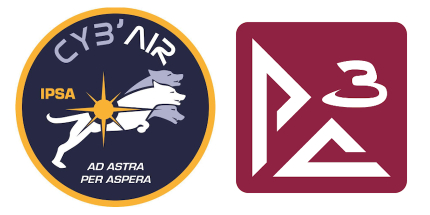

# CRRID Equidistance

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import sympy as sp
from sympy import exp, sqrt
import numpy as np
import cxroots as cx
import matplotlib.pyplot as plt
import time
import math
import warnings 
warnings.filterwarnings("ignore", category=RuntimeWarning)

def toggle_code_cells(btn):
    js_command = """
    var cell = Jupyter.notebook.get_cell(Jupyter.notebook.get_selected_index());
    cell.metadata.jupyter = cell.metadata.jupyter || {};
    if (cell.metadata.jupyter.source_hidden) {
        cell.metadata.jupyter.source_hidden = false;
        cell.element.show();
    } else {
        cell.metadata.jupyter.source_hidden = true;
        cell.element.hide();
    }
    cell.element.trigger('changed');
    """

    display(Javascript(js_command))

btn = widgets.Button(description="Toggle Code Cell")
btn.on_click(toggle_code_cells)

# Créez le widget FloatText
float_text = widgets.FloatText(
    value=1,
    description='m:',
    disabled=False
)

# Créez le widget FloatText
float_text2 = widgets.FloatText(
    value=2,
    description='n:',
    disabled=False
)
float_text3 = widgets.FloatText(
    value=0.5,
    description='val_d:',
    disabled=False
)

# Créez le widget FloatText
float_text4 = widgets.FloatText(
    value=1,
    description='a_haut:',
    disabled=False
)
float_text5 = widgets.FloatText(
    value=0.5,
    description='a_bas:',
    disabled=False
)



# Créez un bouton
button = widgets.Button(description="Lancer le calcul")

# Créez un widget pour afficher le résultat
output = widgets.Output()

# Créez un bouton pour recommencer le calcul
restart_button = widgets.Button(description="Recommencer le calcul")

# Group the FloatText and Button widgets
input_widgets = widgets.VBox([float_text,float_text2,float_text3,float_text4,float_text5, button])

# Créez un conteneur pour tous les widgets
all_widgets = widgets.VBox([input_widgets, output,btn])

progress = widgets.IntProgress(
    value=0,
    min=0,
    max=42,
    step=1,
    description='Loading:',
    bar_style='', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal'
)


# Définissez la fonction à exécuter lorsque le bouton est cliqué
def on_button_clicked(b):
    # Remove the input widgets
    all_widgets.children = [progress]
    # Effacer les résultats précédents
    output.clear_output()
    # Effectuer le calcul et afficher le résultat
    with output:

        start_time = time.time()


        class CRRID:

            def __init__(self, m, n, val_d, a_num):
                self.m = m
                self.n = n
                self.s = sp.symbols('s')
                self.d = sp.symbols('d', positive=True)
                self.value_d = val_d
                self.alpha = sp.symbols(["alpha{:d}".format(i) for i in range(self.m + 1)], real=True)
                self.alpha_num = []
                self.a_num = a_num
                self.tot_poly = 0

            def polynom(self):
                self.tot_poly = self.s ** self.n + np.array(self.a_num).dot([self.s ** i for i in range(self.n)]) + np.array(self.alpha).dot(
                    [self.s ** i for i in range(self.m + 1)]) * exp(-self.s)
                progress.value= progress.value+1

            def system(self):
                """
                contient le 1) du pseudo code (assignation sk = s1 - (k-1)*d)
                contient la constitution du système à résoudre pour étape 2)
                :return:
                """
                self.sys = [self.tot_poly] * (self.n + 1)
                for i in range(self.n + 1):
                    progress.value= progress.value+1
                    self.sys[i] = self.sys[i].subs(self.s, self.s - i * self.d)

            def solve(self):
                """
                étape 2) : résout les alpha et s1
                :return:
                """
                self.sol = sp.solve(self.sys, self.alpha + [self.s], dict=True)[1]
                progress.value= progress.value+1
                self.v1 = self.sol[sp.symbols("s")]

                for i in range(len(self.alpha)):
                    self.alpha_num.append(self.sol[self.alpha[i]])
                    progress.value= progress.value+1
                    self.alpha_num[i] = self.alpha_num[i].subs(self.d, self.value_d)
                    self.tot_poly = self.tot_poly.subs(self.alpha[i], self.alpha_num[i])

            def root_plots(self):
                """
                étape 6) Tracé du spectre
                étape 5) substitution dans F

                :return:
                """

                derivees = [self.tot_poly]
                derivees.append(self.tot_poly.diff(self.s))
                func = []

                for i in range(len(derivees)):
                    derivees[i] = derivees[i].subs({alphai: alphai_num for alphai, alphai_num in zip(self.alpha, self.alpha_num)})
                    func.append(sp.lambdify(self.s, derivees[i]))
                    progress.value= progress.value+1
                print(derivees[0])

                rect = cx.Rectangle([-10, 0], [-100, 100])
                progress.value= progress.value+1
                roots = rect.roots(func[0], func[1], root_err_tol=1e-3, abs_tol=1e-5)
                progress.value= progress.value+1
                print(roots)
                xroot = np.real(roots[0])
                yroot = np.imag(roots[0])

                fig, ax = plt.subplots(figsize=(5, 5))
                progress.value= progress.value+1
                ax.scatter([xroot], [yroot])
                ax.grid(True)
                ax.set_axisbelow(True)
                ax.set_xlabel("Real part")
                ax.set_ylabel("Imaginary part")
                plt.show()

            def admission_plots(self):
                """
                étape 3)
                :return:
                """
                d = sp.symbols('d', positive=True)
                x = np.linspace(0, 4, 100)  # Création d'un tableau de valeurs pour x
                y_func = sp.lambdify(d, self.v1) # Calcul de y à partir de la fonction mathématique
                y = y_func(x)

                indices_liste = []
                for i in range(np.size(y)):
                    if math.isnan(y[i]):
                        progress.value= progress.value+1
                        indices_liste.append(i)
                liste_y = np.delete(y,indices_liste)
                liste_x = np.delete(x,indices_liste)

                index_ymax = np.argmax(liste_y)
                plt.plot(x, y)  # Tracé de la courbe
                progress.value= progress.value+1
                plt.title("Admission de la distance")  # Titre
                plt.xlabel('d')  # Légende abscisse
                plt.ylabel('v1')  # Légende ordonnée
                plt.grid()  # Ajout d'une grille
                plt.axvline(x=liste_x[index_ymax], color='r')
                progress.value= progress.value+1
                plt.axhline(y= max(liste_y), color='r')
                progress.value= progress.value+1
                plt.show()  # Affichage

            def run(self):
                self.polynom()
                progress.value= progress.value+1
                self.system()
                progress.value= progress.value+1
                self.solve()
                progress.value= progress.value+1
                self.admission_plots()
                progress.value= progress.value+1
                self.root_plots()


        object = CRRID(1, 2, 0.5, [1, 0.5])
        object.run()
        print("--- %s seconds ---" % (time.time() - start_time))
    all_widgets.children = [output, restart_button]

# Attachez la fonction au bouton
button.on_click(on_button_clicked)

def on_restart_button_clicked(b):
    # Effacer les résultats précédents
    output.clear_output()
    # Réinitialiser la valeur du widget FloatText
    float_text.value = 1
    float_text2.value = 2
    float_text3.value = 0.5
    float_text4.value = 1
    float_text5.value = 0.5
    # Add back the input widgets
    all_widgets.children = [input_widgets, output]

# Attachez la fonction au bouton de redémarrage
restart_button.on_click(on_restart_button_clicked)

# Affichez les widgets


display(all_widgets)